In [100]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import numpy as np

from textwrap import wrap

In [101]:
bls_work_stoppages_file_location = 'Dataset/work_stoppages_BLS.csv'  

def read_numeric_cell_with_commas(cell):
    try:
        return int(cell.replace(',',''))
    except:
        return 0

split_string_by_comma = lambda s: pd.Series(str(s).split(','))

dtypes = {
    'Organizations involved': 'category',
    'Ownership': 'category',
    'Industry code[1]': 'category'
}

renamed_columns = {
    'Days idle, cumulative for this work stoppage[3]': 'Cumulative days idle',
    'Number of workers[2]': 'Number of workers',
    'Work stoppage beginning date': 'Beginning date',
    'Work stoppage ending date': 'Ending date',
    'Industry code[1]': 'Industry code'

}

column_converters = {
    'States': split_string_by_comma,
    'Union acronym': split_string_by_comma,
    'Days idle, cumulative for this work stoppage[3]': read_numeric_cell_with_commas, 
    'Number of workers[2]': read_numeric_cell_with_commas
}

other_columns_to_use = ['States', 'Union acronym']


bls_dataframe = pd.read_csv(bls_work_stoppages_file_location, 
    dtype=dtypes, 
    usecols=list(dtypes) + list(renamed_columns) + other_columns_to_use, 
    parse_dates=['Work stoppage beginning date','Work stoppage ending date'],
    converters=column_converters)

bls_dataframe = bls_dataframe.rename(columns=renamed_columns)

# Adding columns we'll want to play with later
bls_dataframe['Year'] = bls_dataframe['Beginning date'].map(lambda x: x.year)
bls_dataframe['Length (days)'] = bls_dataframe.apply(lambda x: (x['Ending date'] - x['Beginning date']).days, axis=1)

bls_dataframe.head()



,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days)
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 ...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0


In [102]:
bls_industry_codes_file_location = 'Dataset/bls_naics_2022_titles_descriptions_exploded.csv'

industry_codes_df = pd.read_csv(bls_industry_codes_file_location, usecols=['2022 NAICS','2022 NAICS Short Title'], dtype={'2022 NAICS' : 'string'})

industry_codes_df = industry_codes_df.rename(columns={'2022 NAICS': 'Industry code', '2022 NAICS Short Title': 'Industry Name'})
industry_codes_df = industry_codes_df.set_index('Industry code')

bls_dataframe['Industry category code'] = bls_dataframe['Industry code'].map(lambda x: x[:2])
bls_dataframe = bls_dataframe.join(industry_codes_df, on='Industry category code').rename(columns={'Industry Name': 'Industry'})
bls_dataframe.head()

,Organizations involved,States,Ownership,Industry code,Union acronym,Beginning date,Ending date,Number of workers,Cumulative days idle,Year,Length (days),Industry category code,Industry
0,Association of National Advertisers; American ...,0 AR 1 MA 2 IL 3 OH 4 ...,Private industry,54181,0 AFTRA 1 SAG dtype: object,2000-05-01,2000-10-30,135000,17280000,2000,182.0,54,"Professional, Scientific, and Technical Services"
1,"Albertsons, Ralphs, and Vons Markets",0 CA dtype: object,Private industry,445110,0 UFCW dtype: object,2003-10-12,2004-02-29,67300,5718100,2003,140.0,44,Retail Trade
2,"Caterpillar, Inc.",0 IL 1 MI 2 PA 3 CO dtype: object,Private industry,3331,0 UAW dtype: object,1994-06-20,1995-12-03,14000,4063000,1994,531.0,33,Manufacturing
3,General Motors Corp.,0 Interstate dtype: object,Private industry,3361,0 UAW dtype: object,1998-06-05,1998-07-29,152200,3313000,1998,54.0,33,Manufacturing
4,Marine Towing and Transportation Employers' As...,0 NY dtype: object,Private industry,488330,0 ILA dtype: object,1988-02-16,1993-12-20,2500,2879500,1988,2134.0,48,Transportation and Warehousing


In [103]:
# grouped_by_state = bls_dataframe.groupby(['States']).agg({
#     'Number of workers': ['sum', 'mean'],
#     'Cumulative days idle': ['sum','mean']
# }).reset_index(names=['States'])

bls_dataframe_exploded_by_states = bls_dataframe.explode(column='States')
bls_dataframe_exploded_by_states = bls_dataframe_exploded_by_states[bls_dataframe_exploded_by_states['States'].str.len() == 2]

grouped_by_state = bls_dataframe_exploded_by_states.groupby('States').agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['States'])

grouped_by_state.columns = grouped_by_state.columns.map(' '.join)
grouped_by_state = grouped_by_state.rename(columns={'States ' : 'State', 'Number of workers count' : 'Number of strikes'})

grouped_by_state


,State,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,AK,3900,1950.000000,2,12700,6.350000e+03
1,AL,54200,5420.000000,10,1393200,1.393200e+05
2,AR,137900,45966.666667,3,17320000,5.773333e+06
3,AZ,87500,17500.000000,5,1045500,2.091000e+05
4,CA,936700,6787.681159,138,9766700,7.077319e+04
5,CO,96800,10755.555556,9,866600,9.628889e+04
6,CT,64400,5854.545455,11,623800,5.670909e+04
7,DC,5100,1275.000000,4,128600,3.215000e+04
8,GA,5900,2950.000000,2,119500,5.975000e+04
9,HI,36200,5171.428571,7,399600,5.708571e+04


In [104]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of strikes', 
    hover_name='Number of strikes',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='# strikes by state')
fig.show()

In [105]:



fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers mean', 
    hover_name='State',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Average # Striking Workers by State')
fig.show()

In [106]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Number of workers sum', 
    hover_name='State',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Total # Striking Workers by State')
fig.show()

In [107]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle sum', 
    hover_name='Cumulative days idle sum',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Total length of all strikes')
fig.show()

In [108]:
fig = px.choropleth(grouped_by_state, 
    locations='State', 
    locationmode='USA-states', 
    color='Cumulative days idle mean', 
    hover_name='Cumulative days idle mean',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='usa')

fig.update_layout(title='Average length of strike by state')
fig.show()

In [109]:
grouped_by_ownership = bls_dataframe.groupby(['Ownership']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Ownership'])

grouped_by_ownership.columns = grouped_by_ownership.columns.map(' '.join)
grouped_by_ownership = grouped_by_ownership.rename(columns={'Ownership ' : 'Ownership', 'Number of workers count' : 'Number of strikes'})

grouped_by_ownership

C:\Users\emmaf\AppData\Local\Temp\ipykernel_34028\3362711432.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Ownership,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,Local government,574200,5416.981132,106,3077200,29030.188679
1,Private industry,3194800,7115.367483,449,77066900,171641.202673
2,State and local government,15800,15800.000000,1,136500,136500.000000
3,State government,851000,17020.000000,50,3031100,60622.000000


Text(0.5, 1.0, '# Strikes by Ownership type')

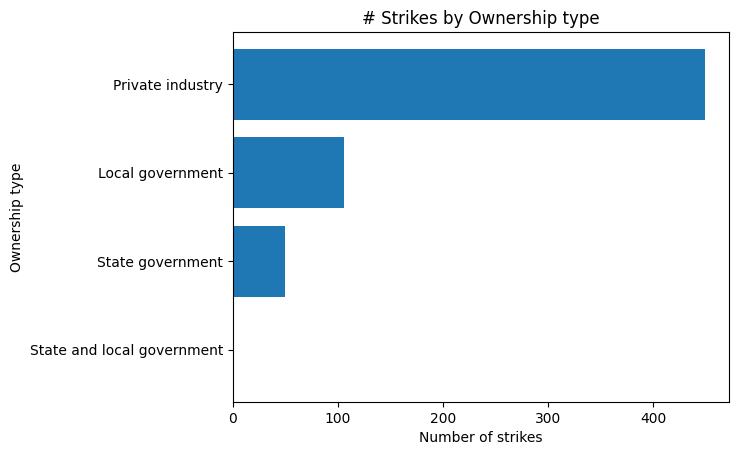

In [110]:
df_sorted = grouped_by_ownership.sort_values(by='Number of strikes', ascending=True)
plt.barh(df_sorted['Ownership'], df_sorted['Number of strikes'])
plt.xlabel('Number of strikes')
plt.ylabel('Ownership type')
plt.title('# Strikes by Ownership type')

In [111]:
grouped_by_industry = bls_dataframe.groupby(['Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Industry'])

grouped_by_industry.columns = grouped_by_industry.columns.map(' '.join)
grouped_by_industry = grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})
# grouped_by_industry[grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services']['Industry'] = 'Admin Support'
grouped_by_industry.loc[grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'
grouped_by_industry

,Industry,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,Accommodation and Food Services,44000,4400.000000,10,751100,7.511000e+04
1,Admin Support,41100,3425.000000,12,397000,3.308333e+04
2,"Arts, Entertainment, and Recreation",3400,1700.000000,2,184600,9.230000e+04
3,Construction,151800,2448.387097,62,1414500,2.281452e+04
4,Educational Services,939400,9585.714286,98,4212100,4.298061e+04
5,Finance and Insurance,7500,1875.000000,4,173600,4.340000e+04
6,Health Care and Social Assistance,574900,6051.578947,95,2078400,2.187789e+04
7,Information,486300,23157.142857,21,5583700,2.658905e+05
8,Manufacturing,1124000,6771.084337,166,28180200,1.697602e+05
9,"Mining, Quarrying, and Oil and Gas Extraction",41500,4150.000000,10,3393100,3.393100e+05


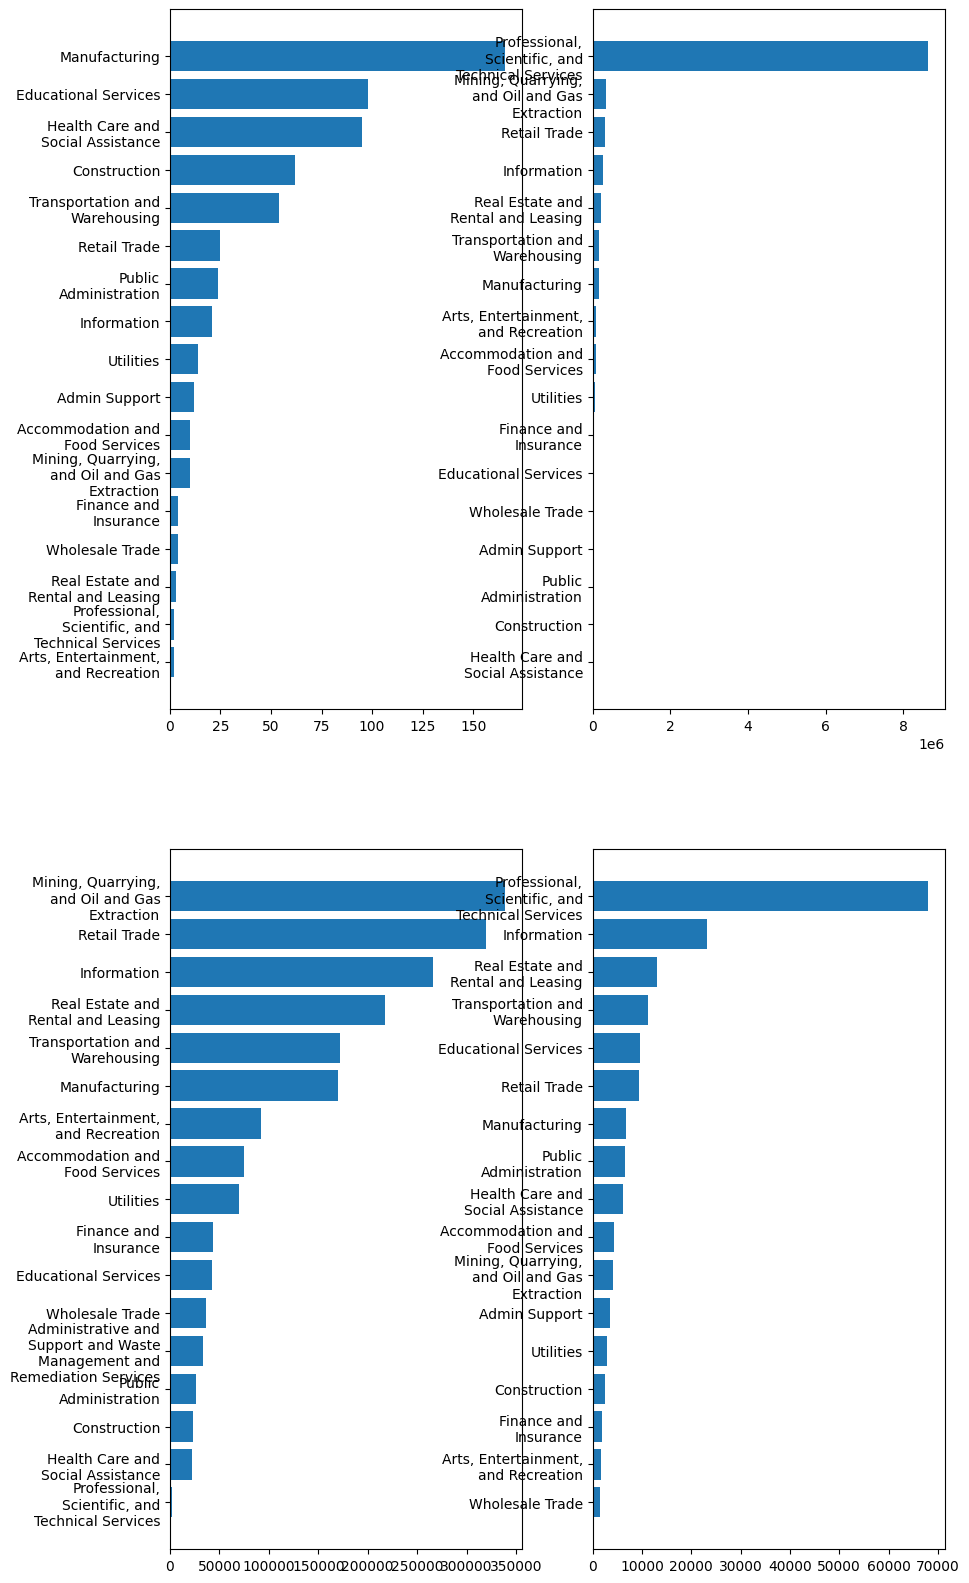

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 2)

fig.set_figheight(20)
fig.set_figwidth(10)

grouped_by_industry['Industry'] = grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 20)))

df_sorted = grouped_by_industry.sort_values(by='Number of strikes', ascending=True)
ax1[0].barh(df_sorted['Industry'], df_sorted['Number of strikes'])
# ax1[0].xlabel('Number of strikes')
# ax1[0].ylabel('Industry')
# ax1[0].title('# Strikes by Industry')

df_sorted = grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
ax1[1].barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# ax1[1].xlabel('Average # Days Idle')
# ax1[1].ylabel('Industry')
# ax1[1].title('Average Cumulative Days Idle by Industry')

# There's one SAG-AFTRA strike where this number is an order of magnitude larger then every other entry, let's filter it out
filter_out_sag_aftra = bls_dataframe[bls_dataframe['Cumulative days idle'] < 10000000]

filtered_grouped_by_industry = filter_out_sag_aftra.groupby(['Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Industry'])


filtered_grouped_by_industry['Industry'] = filtered_grouped_by_industry['Industry'].apply(lambda x: '\n'.join(wrap(x, 20)))

filtered_grouped_by_industry.columns = filtered_grouped_by_industry.columns.map(' '.join)
filtered_grouped_by_industry = filtered_grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})
filtered_grouped_by_industry.loc[filtered_grouped_by_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

df_sorted = filtered_grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
ax2[0].barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# ax2[0].xlabel('Average # Days Idle')
# ax2[0].ylabel('Industry')
# ax2[0].title('Average Cumulative Days Idle by Industry (Filtered)')

df_sorted = grouped_by_industry.sort_values(by='Number of workers mean', ascending=True)
ax2[1].barh(df_sorted['Industry'], df_sorted['Number of workers mean'])
# ax2[1].xlabel('Average # Workers')
# ax2[1].ylabel('Industry')
# ax2[1].title('Average Size of Strikes by Industry')

plt.show()

In [113]:
# df_sorted = grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
# plt.barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# plt.xlabel('Average # Days Idle')
# plt.ylabel('Industry')
# plt.title('Average Cumulative Days Idle by Industry')

In [114]:

# # There's one SAG-AFTRA strike where this number is an order of magnitude larger then every other entry, let's filter it out
# filter_out_sag_aftra = bls_dataframe[bls_dataframe['Cumulative days idle'] < 10000000]

# filtered_grouped_by_industry = filter_out_sag_aftra.groupby(['Industry']).agg({
#     'Number of workers': ['sum', 'mean', 'count'],
#     'Cumulative days idle': ['sum','mean']
# }).reset_index(names=['Industry'])

# filtered_grouped_by_industry.columns = filtered_grouped_by_industry.columns.map(' '.join)
# filtered_grouped_by_industry = filtered_grouped_by_industry.rename(columns={'Industry ' : 'Industry', 'Number of workers count' : 'Number of strikes'})

# df_sorted = filtered_grouped_by_industry.sort_values(by='Cumulative days idle mean', ascending=True)
# plt.barh(df_sorted['Industry'], df_sorted['Cumulative days idle mean'])
# plt.xlabel('Average # Days Idle')
# plt.ylabel('Industry')
# plt.title('Average Cumulative Days Idle by Industry (Filtered)')

In [115]:
# df_sorted = grouped_by_industry.sort_values(by='Number of workers mean', ascending=True)
# plt.barh(df_sorted['Industry'], df_sorted['Number of workers mean'])
# plt.xlabel('Average # Workers')
# plt.ylabel('Industry')
# plt.title('Average Size of Strikes by Industry')

In [116]:

grouped_by_year = bls_dataframe.groupby(['Year']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year'])

grouped_by_year.columns = grouped_by_year.columns.map(' '.join)
grouped_by_year = grouped_by_year.rename(columns={'Year ' : 'Year', 'Number of workers count' : 'Number of strikes'})
grouped_by_year

,Year,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,1988,2500,2500.000000,1,2879500,2.879500e+06
1,1993,181900,5197.142857,35,3597800,1.027943e+05
2,1994,324500,7211.111111,45,7948100,1.766244e+05
3,1995,190300,6343.333333,30,3476900,1.158967e+05
4,1996,272700,7370.270270,37,5246100,1.417865e+05
5,1997,338600,11675.862069,29,3527900,1.216517e+05
6,1998,386800,11376.470588,34,6692100,1.968265e+05
7,1999,72600,4270.588235,17,961000,5.652941e+04
8,2000,393700,10094.871795,39,19911500,5.105513e+05
9,2001,99100,3417.241379,29,1143200,3.942069e+04


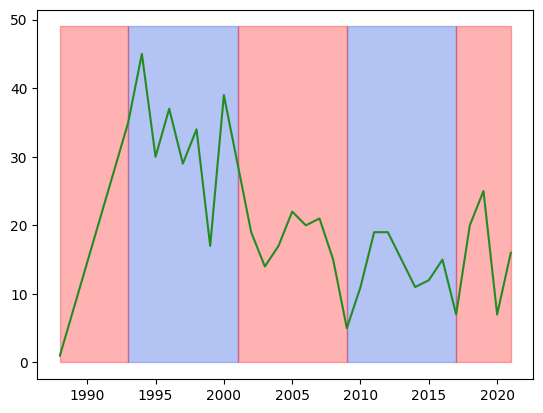

In [117]:
plt.plot(grouped_by_year['Year'], grouped_by_year['Number of strikes'], color='forestgreen')

# ax = plt.gca()
y = np.arange(0, 50)
# years with a Democratic president are shaded in blue
plt.fill_betweenx(y, 1993, 2001, alpha=0.4, color='royalblue')
plt.fill_betweenx(y, 2009, 2017, alpha=0.4, color='royalblue')

#years with a Republican president are shaded in red
plt.fill_betweenx(y, 1988, 1993, alpha=0.3, color='red')
plt.fill_betweenx(y, 2001, 2009, alpha=0.3, color='red')
plt.fill_betweenx(y, 2017, 2021, alpha=0.3, color='red')



In [118]:
grouped_by_year_and_industry = bls_dataframe[(bls_dataframe['Year'] >= 1993) & (bls_dataframe['Year'] <=2021)].groupby(['Year', 'Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year', 'Industry'])

grouped_by_year_and_industry.columns = grouped_by_year_and_industry.columns.map(' '.join)
grouped_by_year_and_industry = grouped_by_year_and_industry.rename(columns={'Industry ' : 'Industry', 'Year ': 'Year', 'Number of workers count' : 'Number of strikes'})
# grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services']['Industry'] = 'Admin Support'
grouped_by_year_and_industry.loc[grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

# industries = grouped_by_year_and_industry['Industry'].unique()
# years = grouped_by_year_and_industry['Year'].unique()

# to_add = []

# for industry in industries:
#     industry_data = grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == industry]
#     # if data doesn't exist for a particular year we want to add
#     for year in years:
#         if year not in industry_data['Year']:
#             to_append = to_add.append([year, industry,0,0,0,0,0])
#     num_strikes = grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == industry].sort_values(by='Year', ascending=True)['Number of strikes']

# df = pd.DataFrame(to_add, columns=['Year', 'Industry', 'Number of workers sum',	'Number of workers mean', 'Number of strikes', 'Cumulative days idle sum',	'Cumulative days idle mean'])
# grouped_by_year_and_industry = pd.concat([grouped_by_year_and_industry, df])
       

grouped_by_year_and_industry

,Year,Industry,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,1993,Admin Support,1800,1800.0,1,12600,12600.0
1,1993,Construction,5600,2800.0,2,45600,22800.0
2,1993,Educational Services,11500,2300.0,5,58100,11620.0
3,1993,Finance and Insurance,3400,3400.0,1,115600,115600.0
4,1993,Health Care and Social Assistance,12000,12000.0,1,12000,12000.0
...,...,...,...,...,...,...,...
205,2021,Educational Services,7200,2400.0,3,201000,67000.0
206,2021,Health Care and Social Assistance,45400,11350.0,4,118800,29700.0
207,2021,Manufacturing,16600,3320.0,5,531600,106320.0
208,2021,"Mining, Quarrying, and Oil and Gas Extraction",1100,1100.0,1,205700,205700.0


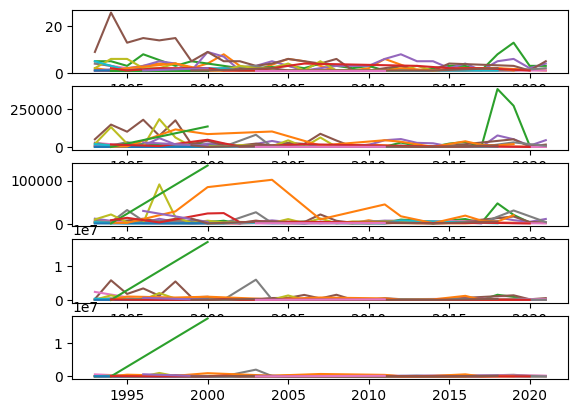

In [119]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)

for industry in industries:
    industry_data = grouped_by_year_and_industry[grouped_by_year_and_industry['Industry'] == industry].sort_values(by='Year', ascending=True)
    years = industry_data['Year']

    num_strikes = industry_data['Number of strikes']
    ax1.plot(pd.Series(years), num_strikes, label=industry)

    sum_workers = industry_data['Number of workers sum']
    ax2.plot(pd.Series(years), sum_workers, label=industry)

    avg_workers = industry_data['Number of workers mean']
    ax3.plot(pd.Series(years), avg_workers, label=industry)

    days_idle_sum = industry_data['Cumulative days idle sum']
    ax4.plot(pd.Series(years), days_idle_sum, label=industry)

    days_idle_mean = industry_data['Cumulative days idle mean']
    ax5.plot(pd.Series(years), days_idle_mean, label=industry)

plt.show()

In [120]:
filtered_grouped_by_year_and_industry = filter_out_sag_aftra[(filter_out_sag_aftra['Year'] >= 1993) & (filter_out_sag_aftra['Year'] <=2021)].groupby(['Year', 'Industry']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year', 'Industry'])

filtered_grouped_by_year_and_industry.columns = filtered_grouped_by_year_and_industry.columns.map(' '.join)
filtered_grouped_by_year_and_industry = filtered_grouped_by_year_and_industry.rename(columns={'Industry ' : 'Industry', 'Year ': 'Year', 'Number of workers count' : 'Number of strikes'})
# filtered_grouped_by_year_and_industry[filtered_grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services']['Industry'] = 'Admin Support'
filtered_grouped_by_year_and_industry.loc[filtered_grouped_by_year_and_industry['Industry'] == 'Administrative and Support and Waste Management and Remediation Services', 'Industry'] = 'Admin Support'

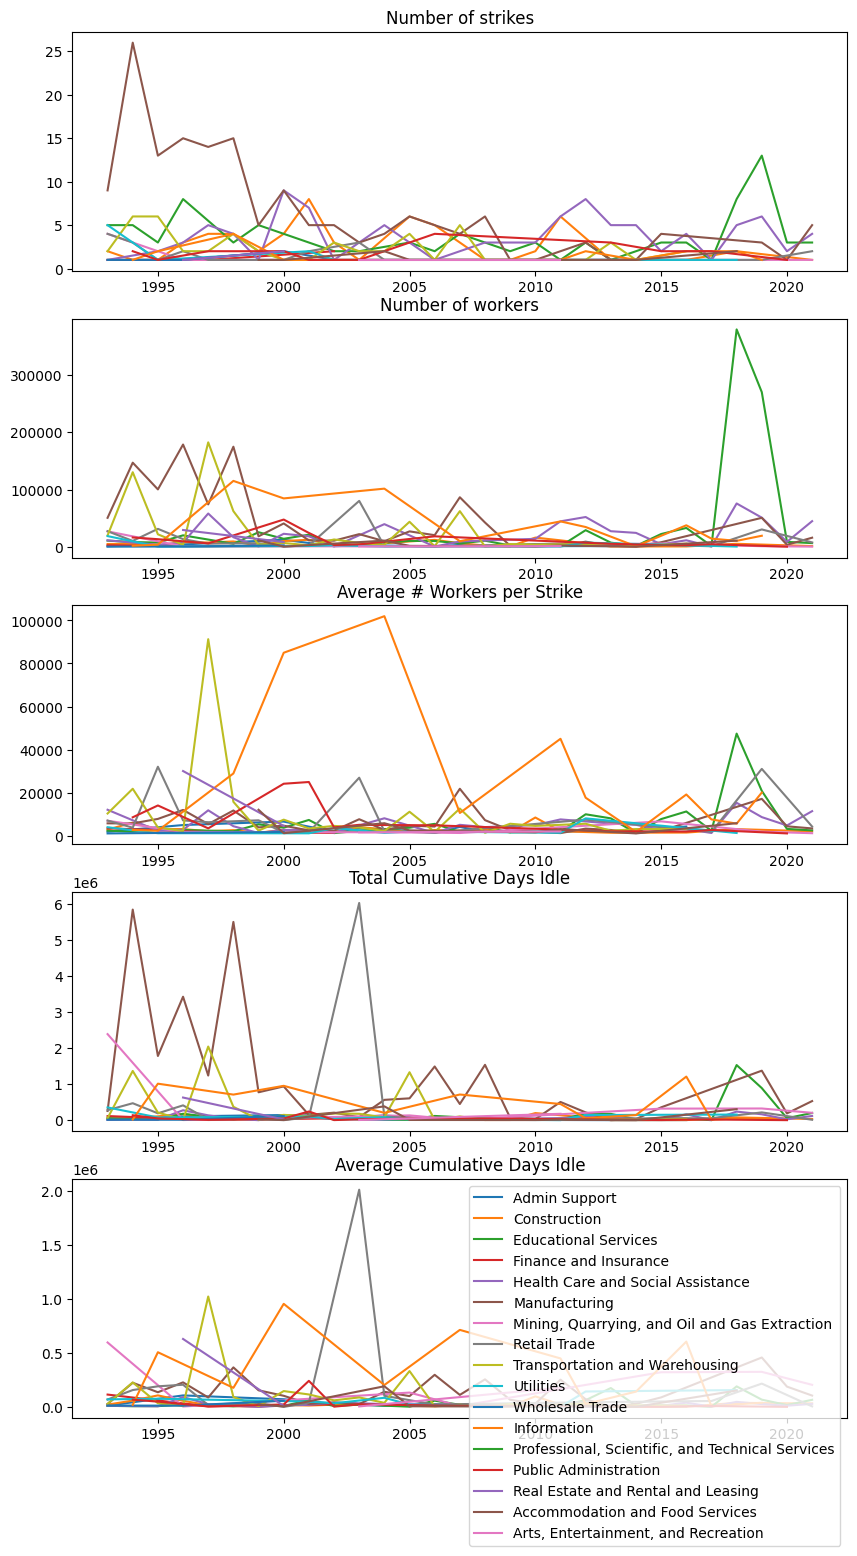

In [126]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)

fig.set_figheight(18)
fig.set_figwidth(10)

for industry in industries:
    industry_data = filtered_grouped_by_year_and_industry[filtered_grouped_by_year_and_industry['Industry'] == industry].sort_values(by='Year', ascending=True)
    years = industry_data['Year']

    num_strikes = industry_data['Number of strikes']
    ax1.plot(pd.Series(years), num_strikes, label=industry)
    ax1.set_title('Number of strikes')

    sum_workers = industry_data['Number of workers sum']
    ax2.plot(pd.Series(years), sum_workers, label=industry)
    ax2.set_title('Number of workers')

    avg_workers = industry_data['Number of workers mean']
    ax3.plot(pd.Series(years), avg_workers, label=industry)
    ax3.set_title('Average # Workers per Strike')

    days_idle_sum = industry_data['Cumulative days idle sum']
    ax4.plot(pd.Series(years), days_idle_sum, label=industry)
    ax4.set_title('Total Cumulative Days Idle')

    days_idle_mean = industry_data['Cumulative days idle mean']
    ax5.plot(pd.Series(years), days_idle_mean, label=industry)
    ax5.set_title('Average Cumulative Days Idle')

plt.legend()
plt.show()

In [ ]:
grouped_by_year_and_ownership = bls_dataframe[(bls_dataframe['Year'] >= 1993) & (bls_dataframe['Year'] <=2021)].groupby(['Year', 'Ownership']).agg({
    'Number of workers': ['sum', 'mean', 'count'],
    'Cumulative days idle': ['sum','mean']
}).reset_index(names=['Year', 'Ownership'])

grouped_by_year_and_ownership.columns = grouped_by_year_and_ownership.columns.map(' '.join)
grouped_by_year_and_ownership = grouped_by_year_and_ownership.rename(columns={'Ownership ' : 'Ownership', 'Year ': 'Year', 'Number of workers count' : 'Number of strikes'})
# grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == 'Administrative and Support and Waste Management and Remediation Services']['Ownership'] = 'Admin Support'
# grouped_by_year_and_ownership.loc[grouped_by_year_and_ownership['Ownership'] == 'Administrative and Support and Waste Management and Remediation Services', 'Ownership'] = 'Admin Support'

ownership_types = grouped_by_year_and_ownership['Ownership'].unique()
years = grouped_by_year_and_ownership['Year'].unique()

# to_add = []

# for ownership_type in ownership_types:
#     ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type]
#     # if data doesn't exist for a particular year we want to add
#     for year in years:
#         if year not in ownership_data['Year']:
#             to_append = to_add.append([year, ownership_type,0,0,0,0,0])

# df = pd.DataFrame(to_add, columns=['Year', 'Ownership', 'Number of workers sum', 'Number of workers mean', 'Number of strikes', 'Cumulative days idle sum',	'Cumulative days idle mean'])
# grouped_by_year_and_ownership = pd.concat([grouped_by_year_and_ownership, df])
       

grouped_by_year_and_ownership

C:\Users\emmaf\AppData\Local\Temp\ipykernel_34028\3550410052.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Year,Ownership,Number of workers sum,Number of workers mean,Number of strikes,Cumulative days idle sum,Cumulative days idle mean
0,1993,Local government,18600,3720.000000,5,104500,20900.000000
1,1993,Private industry,161400,5565.517241,29,3485700,120196.551724
2,1993,State and local government,0,NaN,0,0,NaN
3,1993,State government,1900,1900.000000,1,7600,7600.000000
4,1994,Local government,22800,2850.000000,8,96600,12075.000000
...,...,...,...,...,...,...,...
111,2020,State government,5700,2850.000000,2,45700,22850.000000
112,2021,Local government,2000,2000.000000,1,22000,22000.000000
113,2021,Private industry,78700,5246.666667,15,1081700,72113.333333
114,2021,State and local government,0,NaN,0,0,NaN


     Year         Ownership  Number of workers sum  Number of workers mean  \
0    1993  Local government                  18600             3720.000000   
4    1994  Local government                  22800             2850.000000   
8    1995  Local government                   7100             2366.666667   
12   1996  Local government                  18400             3066.666667   
16   1997  Local government                   4800             2400.000000   
20   1998  Local government                   4800             2400.000000   
24   1999  Local government                  14000             4666.666667   
28   2000  Local government                  63400            12680.000000   
32   2001  Local government                   6900             6900.000000   
36   2002  Local government                   9100             1820.000000   
40   2003  Local government                  11200             5600.000000   
44   2004  Local government                   9200             4

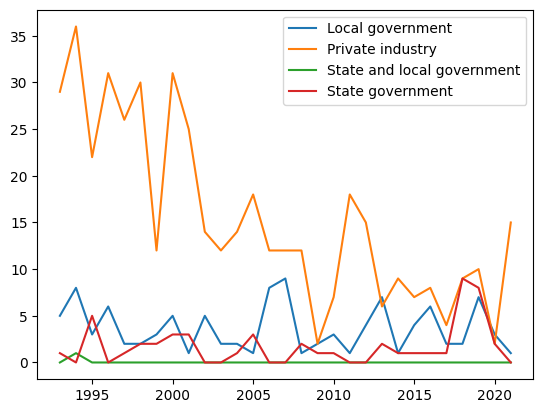

In [ ]:
for ownership_type in ownership_types:
    ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type].sort_values(by='Year', ascending=True)
    years = ownership_data['Year']
    num_strikes = ownership_data['Number of strikes']
    plt.plot(pd.Series(years), num_strikes, label=ownership_type)

plt.legend()
plt.show()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)

fig.set_figheight(18)
fig.set_figwidth(10)

for ownership_type in ownership_types:
    ownership_data = grouped_by_year_and_ownership[grouped_by_year_and_ownership['Ownership'] == ownership_type].sort_values(by='Year', ascending=True)
    years = ownership_data['Year']

    num_strikes = ownership_data['Number of strikes']
    ax1.plot(pd.Series(years), num_strikes, label=ownership_type)
    ax1.set_title('Number of strikes')

    sum_workers = ownership_data['Number of workers sum']
    ax2.plot(pd.Series(years), sum_workers, label=ownership_type)
    ax2.set_title('Number of workers')

    avg_workers = ownership_data['Number of workers mean']
    ax3.plot(pd.Series(years), avg_workers, label=ownership_type)
    ax3.set_title('Average # Workers per Strike')

    days_idle_sum = ownership_data['Cumulative days idle sum']
    ax4.plot(pd.Series(years), days_idle_sum, label=ownership_type)
    ax4.set_title('Total Cumulative Days Idle')

    days_idle_mean = ownership_data['Cumulative days idle mean']
    ax5.plot(pd.Series(years), days_idle_mean, label=ownership_type)
    ax5.set_title('Average Cumulative Days Idle')

plt.legend()
plt.show()